In [ ]:
# default_exp image_rect

# Image Rectification

In [ ]:
# export
import PIL
import torch
from camera_calib.utils import *

In [ ]:
import re
from pathlib import Path

import camera_calib.api as api
import matplotlib.pyplot as plt
import scipy
from camera_calib.modules import Inverse, Rigids
from camera_calib.plot import plot_extrinsics
from camera_calib.utils import *

# Utility

In [ ]:
# export
def save_16bit(arr, file_img):
    pim = PIL.Image.fromarray((torch2np(arr)*(2**16-1)).astype(np.uint16), mode='I;16')
    pim.save(file_img)    

In [ ]:
# export
def distort_coords(ps, cam, distort):
    p2pd = torch.nn.Sequential(Inverse(cam), distort, cam)
    return p2pd(ps)

In [ ]:
# export
def undistort_array(arr, cam, distort, **kwargs):
    return interp_array(arr, distort_coords(array_ps(arr), cam, distort), **kwargs).reshape(arr.shape)

# Rectify

In [ ]:
dir_imgs = Path('data/dot_vision_checker')

In [ ]:
def _parse_name(name_img):
    match = re.match(r'''SERIAL_(?P<serial>.*)_
                         DATETIME_(?P<date>.*)_
                         CAM_(?P<cam>.*)_
                         FRAMEID_(?P<frameid>.*)_
                         COUNTER_(?P<counter>.*).png''', 
                     name_img, 
                     re.VERBOSE)
    return match.groupdict()

In [ ]:
imgs = []
for file_img in dir_imgs.glob('*.png'):
    dict_group = _parse_name(file_img.name)
    img = api.File16bitImg(file_img)
    img.idx_cam = int(dict_group['cam'])-1
    img.idx_cb  = int(dict_group['counter'])-1
    imgs.append(img)

In [ ]:
for img in imgs: print(f'{img.name} - cam: {img.idx_cam} - cb: {img.idx_cb}')

SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2 - cam: 1 - cb: 1
SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1 - cam: 0 - cb: 0
SERIAL_16276941_DATETIME_2019-06-07-00:39:19-778185_CAM_2_FRAMEID_0_COUNTER_3 - cam: 1 - cb: 2
SERIAL_16276941_DATETIME_2019-06-07-00:38:19-438631_CAM_2_FRAMEID_0_COUNTER_1 - cam: 1 - cb: 0
SERIAL_19061245_DATETIME_2019-06-07-00:39:19-778134_CAM_1_FRAMEID_0_COUNTER_3 - cam: 0 - cb: 2
SERIAL_19061245_DATETIME_2019-06-07-00:38:48-109705_CAM_1_FRAMEID_0_COUNTER_2 - cam: 0 - cb: 1


## Calibrate

Do a simple calibration

In [ ]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032
cb_geom = api.CbGeom(h_cb, w_cb,
                     api.CpCSRGrid(num_c_h, num_c_w, spacing_c),
                     api.FmCFPGrid(h_f, w_f))

In [ ]:
file_model = Path('models/dot_vision_checker.pth')
detector = api.DotVisionCheckerDLDetector(file_model)

In [ ]:
refiner = api.OpenCVCheckerRefiner(hw_min=5, hw_max=15, cutoff_it=20, cutoff_norm=1e-3)

In [ ]:
calib = api.multi_calib(imgs, cb_geom, detector, refiner)

Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:19-438594_CAM_1_FRAMEID_0_COUNTER_1...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:39:19-778134_CAM_1_FRAMEID_0_COUNTER_3...
Refining control points for: SERIAL_19061245_DATETIME_2019-06-07-00:38:48-109705_CAM_1_FRAMEID_0_COUNTER_2...
Refining single parameters...
 - Iteration: 000 - Norm:    0.02117 - Loss:   64.08690
 - Iteration: 001 - Norm:    0.03960 - Loss:   58.11754
 - Iteration: 002 - Norm:    0.47925 - Loss:   11.09834
 - Iteration: 003 - Norm:    0.17388 - Loss:    7.19586
 - Iteration: 004 - Norm:    0.07121 - Loss:    6.74723
 - Iteration: 005 - Norm:    2.31742 - Loss:    6.59264
 - Iteration: 006 - Norm:    3.79145 - Loss:    6.42720
 - Iteration: 007 - Norm:   33.80756 - Loss:    4.86668
 - Iteration: 008 - Norm:   16.03156 - Loss:    4.64211
 - Iteration: 009 - Norm:   20.48076 - Loss:    4.25913
 - Iteration: 010 - Norm:    0.00000 - Loss:    4.25913
Refining control points 

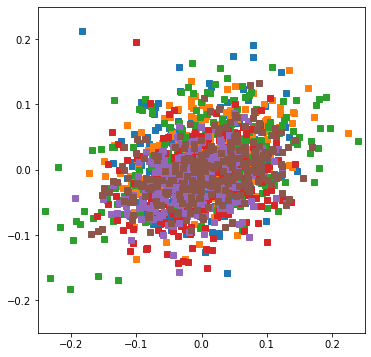

In [ ]:
api.plot_residuals(calib);

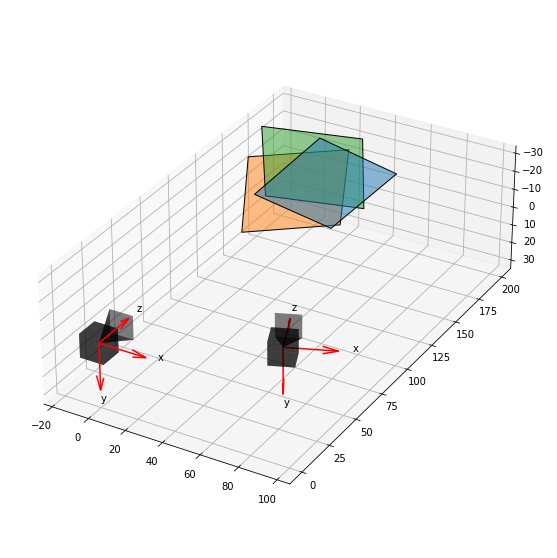

In [ ]:
api.plot_extrinsics(calib);

In [ ]:
api.save(calib, 'data/calib.pth')

Freeze above and just load

In [ ]:
calib = api.load('data/calib.pth')

Parse stuff out

In [ ]:
cam1,     cam2     = calib['cams'][0],       calib['cams'][1]
distort1, distort2 = calib['distorts'][0],   calib['distorts'][1]
rigid1,   rigid2   = calib['rigids_cam'][0], calib['rigids_cam'][1]

## Essential and Fundamental matrices

Normally you would need normalized points (i.e. knowledge of camera matrices) to get the essential matrix, but if you know relative pose via camera calibration, you can compute it directly.

In [ ]:
# export
def get_essential(R12, t12): return cross_mat(t12)@R12

Fundamental matrix only need pixel points, but is also calculable from camera calibration. 

In [ ]:
# export
def get_fundamental(R12, t12, A1, A2):
    E = get_essential(R12, t12)
    return torch.inverse(A2.T)@E@torch.inverse(A1)

Get two example images

In [ ]:
idx_cb = 1

In [ ]:
[img1] = [img for img in imgs if img.idx_cb == idx_cb and img.idx_cam == 0]
[img2] = [img for img in imgs if img.idx_cb == idx_cb and img.idx_cam == 1]
img1, img2

(File16bitImg(SERIAL_19061245_DATETIME_2019-06-07-00:38:48-109705_CAM_1_FRAMEID_0_COUNTER_2),
 File16bitImg(SERIAL_16276941_DATETIME_2019-06-07-00:38:48-109732_CAM_2_FRAMEID_0_COUNTER_2))

Load distorted arrays

In [ ]:
arr1_d = img1.array_gs(torch.double)
arr2_d = img2.array_gs(torch.double)

Undistort arrays first

In [ ]:
with torch.no_grad():
    arr1_u = undistort_array(arr1_d, cam1, distort1)
    arr2_u = undistort_array(arr2_d, cam2, distort2)

I've already computed some corresponding points in undistorted coordinates

In [ ]:
ps1_u = torch.DoubleTensor([[1405.58415842,  479.78877888],
                            [ 750.26829268,  395.88617886],
                            [1246.41509434, 1263.72830189],
                            [ 593.14823529, 1317.16705882]])
ps2_u = torch.DoubleTensor([[1215.77358491,  432.90566038],
                            [ 219.92167102,  368.24020888],
                            [1111.49387755, 1349.13469388],
                            [ 165.30015552, 1371.86314152]])

In [ ]:
idx = 0
p1_u = ps1_u[idx]
p2_u = ps2_u[idx]

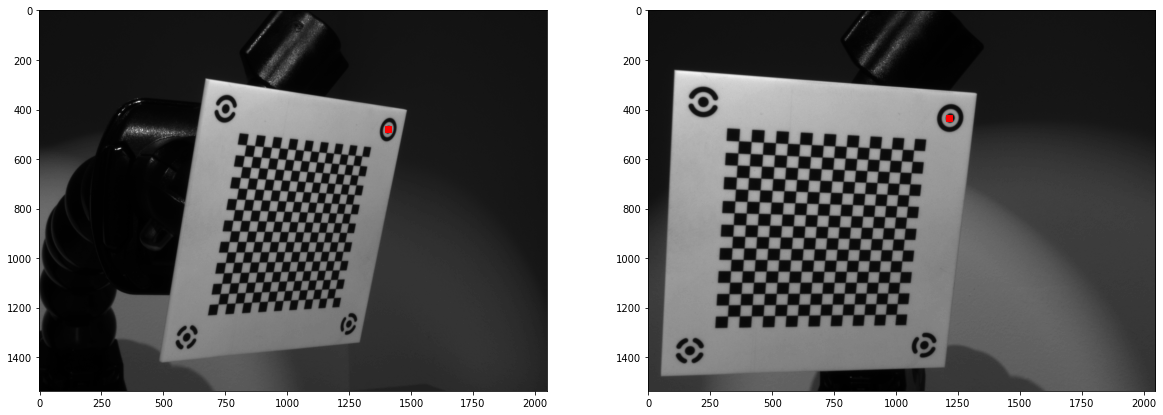

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, arr_u, p_u in zip(axs, [arr1_u, arr2_u], [p1_u, p2_u]):
    ax.imshow(arr_u, cmap='gray')
    ax.plot(p_u[0], p_u[1], 'rs')

Get rigid transform of camera 1 WRT camera 2

In [ ]:
M12 = Rigids([rigid1, Inverse(rigid2)]).get_param()
R12, t12 = M2Rt(M12)
R12, t12

(tensor([[ 9.2388e-01, -1.6450e-04,  3.8268e-01],
         [-2.9211e-03,  9.9997e-01,  7.4820e-03],
         [-3.8267e-01, -8.0303e-03,  9.2385e-01]], dtype=torch.float64),
 tensor([-8.3645e+01,  6.0727e-02, -7.0416e+00], dtype=torch.float64))

In [ ]:
A1 = cam1.get_param()
A2 = cam2.get_param()
A1, A2

(tensor([[3.6058e+03, 0.0000e+00, 9.9057e+02],
         [0.0000e+00, 3.6058e+03, 8.1107e+02],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64),
 tensor([[3.5914e+03, 0.0000e+00, 1.0454e+03],
         [0.0000e+00, 3.5914e+03, 7.9239e+02],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64))

In [ ]:
F = get_fundamental(R12, t12, A1, A2)
F

tensor([[-3.3829e-09,  5.4370e-07, -4.0734e-04],
        [-2.9741e-06, -5.1780e-08,  2.3755e-02],
        [ 2.4124e-03, -2.3724e-02, -2.8407e-01]], dtype=torch.float64)

Check if these satisfy constraint

In [ ]:
augment(p2_u).T@F@augment(p1_u)

tensor(0.0036, dtype=torch.float64)

Appears close to zero... Lets try to plot epipolar line

In [ ]:
def plot_epi(ps1, F, arr1, arr2):
    fig, axs = plt.subplots(1, 2, figsize=(20,20))
    for arr, ax in zip([arr1, arr2], axs): ax.imshow(arr, cmap='gray')
    bb_arr2 = array_bb(arr2)    
    cs = get_colors(len(ps1))
    for p1, c in zip(ps1, cs):
        l2 = F@augment(p1)
        ps2_epi = bb_l_intersect(bb_arr2, l2)
        axs[0].plot(p1[0], p1[1], marker='s', c=c)
        axs[1].plot(ps2_epi[:, 0], ps2_epi[:, 1], c=c)

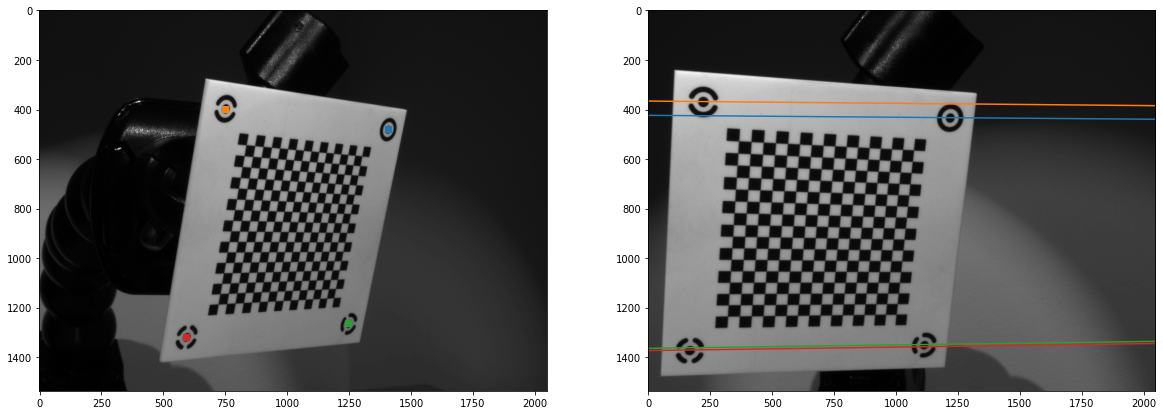

In [ ]:
plot_epi(ps1_u, F, arr1_u, arr2_u)

Epipolar lines look to intersect the same points on the right image

Quick check to see if nullspace of fundamental matrix is the same as the epipole

In [ ]:
e = scipy.linalg.null_space(F)
e /= e[-1]
e

array([[7.97330214e+03],
       [7.98800951e+02],
       [1.00000000e+00]])

In [ ]:
e = -R12.T@t12 # Transform origin of second camera
e = e/e[-1]    # Normalize
e = A1@e       # Apply camera matrix
e

tensor([7.9733e+03, 7.9880e+02, 1.0000e+00], dtype=torch.float64)

## Fusiello Rectification

This method is easier to understand and implement, so lets try it first.

In [ ]:
# export
def fusi_rigid_rect(M1, M2):
    R1, t1 = M2Rt(M1)
    _,  t2 = M2Rt(M2)
    
    # Get rotation matrix
    r1 = t2-t1                     # new x-axis should be parallel to t1->t2 after rotation
    r2 = torch.cross(R1[:, 2], r1) # new y-axis is orthogonal to camera 1's old z axis and new x-axis
    r3 = torch.cross(r1, r2)       # new z-axis is orthogonal to new x and y axes
    r1, r2, r3 = unitize(stackify((r1, r2, r3)))
    R_r = stackify((r1, r2, r3), dim=1)
        
    return Rt2M(R_r, t1), Rt2M(R_r, t2)

In [ ]:
M1 = rigid1.get_param()
M2 = rigid2.get_param()

In [ ]:
M1_r, M2_r = fusi_rigid_rect(M1, M2)
M1_r, M2_r

(tensor([[ 8.8852e-01,  1.7568e-03, -4.5882e-01,  0.0000e+00],
         [-1.5610e-03,  1.0000e+00,  8.0607e-04,  0.0000e+00],
         [ 4.5883e-01,  0.0000e+00,  8.8853e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
        dtype=torch.float64),
 tensor([[ 8.8852e-01,  1.7568e-03, -4.5882e-01,  7.4584e+01],
         [-1.5610e-03,  1.0000e+00,  8.0607e-04, -1.3103e-01],
         [ 4.5883e-01,  0.0000e+00,  8.8853e-01,  3.8514e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
        dtype=torch.float64))

One good check is to rectify twice, which should return the same inputs

In [ ]:
assert_allclose(fusi_rigid_rect(M1_r, M2_r), (M1_r, M2_r))

Get rectified camera matrices

In [ ]:
# export
def fusi_cam_rect(A1, A2):
    A_r = (A1 + A2)/2
    return A_r, A_r

In [ ]:
A1_r, A2_r = fusi_cam_rect(A1, A2)
A1_r, A2_r

(tensor([[3.5986e+03, 0.0000e+00, 1.0180e+03],
         [0.0000e+00, 3.5986e+03, 8.0173e+02],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64),
 tensor([[3.5986e+03, 0.0000e+00, 1.0180e+03],
         [0.0000e+00, 3.5986e+03, 8.0173e+02],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64))

Get rectifying homographies

In [ ]:
# export
def rect_homography(A, A_r, M, M_r):
    (R, t), (R_r, t_r) = map(M2Rt, [M, M_r])
    assert_allclose(t, t_r) # There can be no change in translation for rectification; only rotation
    return A@R.T@R_r@torch.inverse(A_r)    

In [ ]:
H1 = rect_homography(A1, A1_r, M1, M1_r)
H2 = rect_homography(A2, A2_r, M2, M2_r)

Rectify images

In [ ]:
# export
def rect_array(arr_d, H, cam, distort):
    ps_pr = array_ps(arr_d)                                 # Get rectified pixel coordinates
    ps_p  = pmm(ps_pr, H, aug=True)                         # Get pixel coordinates
    ps_pd = distort_coords(ps_p, cam, distort)              # Get distorted coordinates
    arr_r = interp_array(arr_d, ps_pd).reshape(arr_d.shape) # Rectify and undistort image
    return arr_r

In [ ]:
with torch.no_grad():
    arr1_r = rect_array(arr1_d, H1, cam1, distort1)
    arr2_r = rect_array(arr2_d, H2, cam2, distort2)

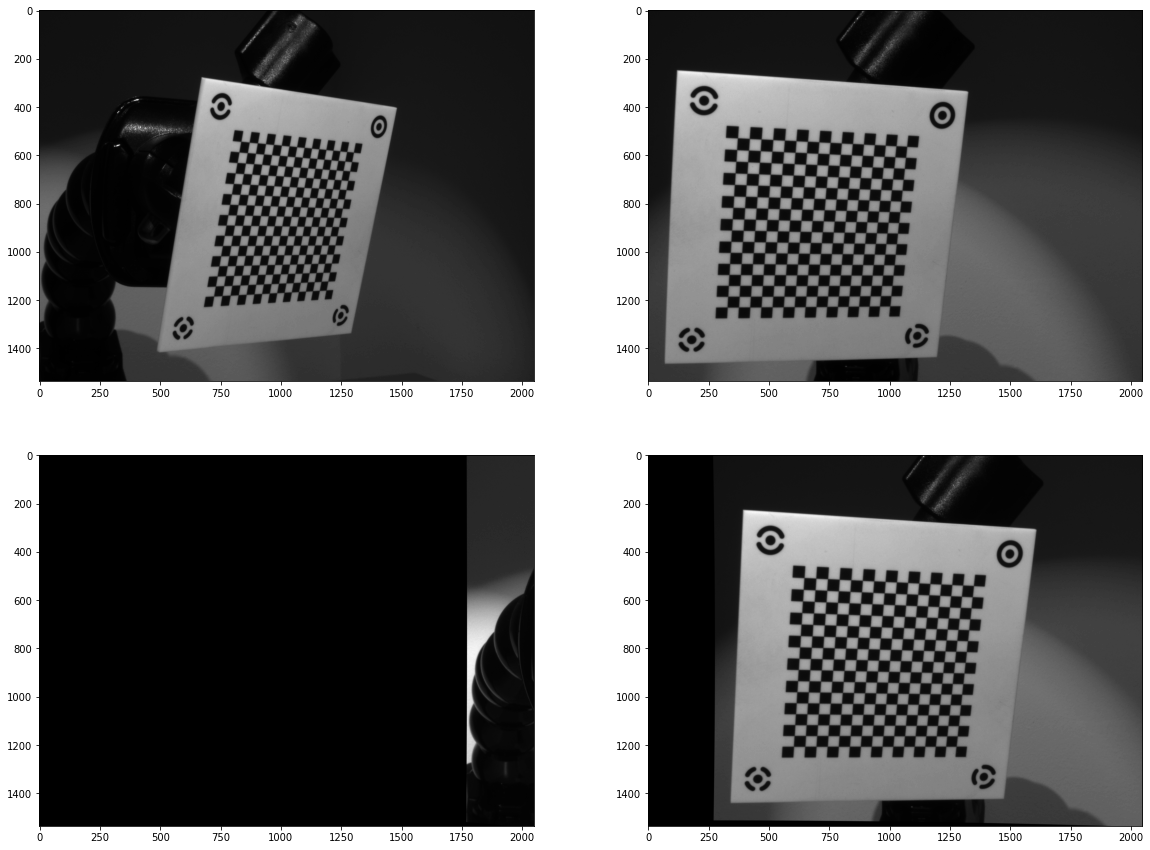

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].imshow(arr1_d, cmap='gray')
axs[0,1].imshow(arr2_d, cmap='gray')
axs[1,0].imshow(arr1_r, cmap='gray')
axs[1,1].imshow(arr2_r, cmap='gray');

To see why the left image is mostly out of FOV, we plot the extrinsics:

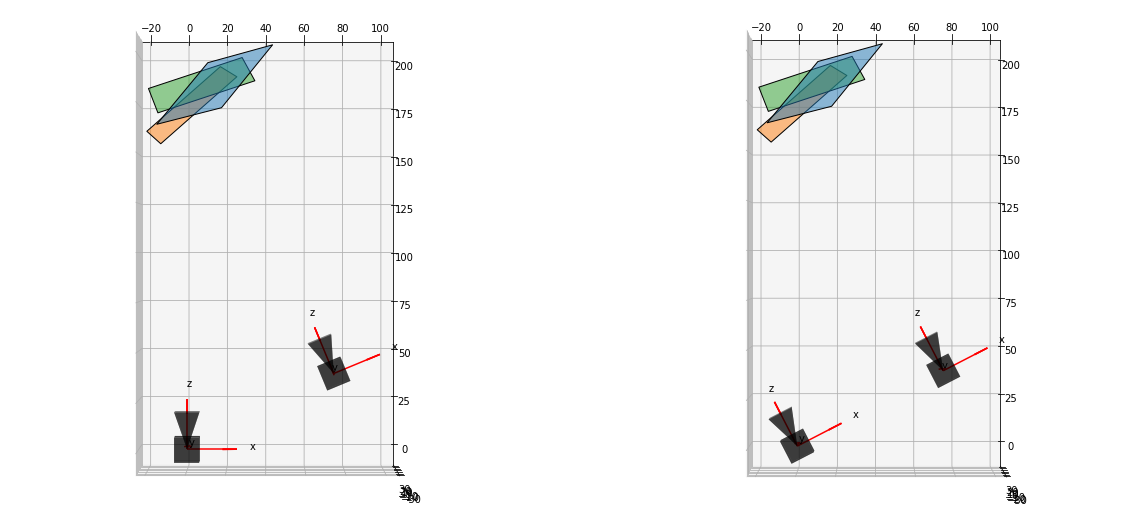

In [ ]:
fig = plt.figure(figsize=(20,15))

ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_extrinsics([rigid_cb.get_param()  for rigid_cb  in calib['rigids_cb']], 
                [M1, M2],
                calib['cb_geom'], 
                ax=ax)
ax.view_init(elev=90, azim=-90)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_extrinsics([rigid_cb.get_param() for rigid_cb in calib['rigids_cb']], 
                [M1_r, M2_r],
                calib['cb_geom'],
                ax=ax)
ax.view_init(elev=90, azim=-90)

The left camera rotates so much that the image goes out of FOV. You can actually fix this by adjusting the camera matrix, but that wasn't included in Fusiello's original paper. I actually like Bouguet's method better though, so we'll do that first.

## Bouguet Rectification

### Rigid Rectification

Bouguet's method aligns cameras by taking mid point rotation (via rodrigues parameterization), then it aligns it by doing shortest rotation to lines formed by principle points.

In [ ]:
# export
def boug_rigid_rect(M1, M2):
    R1, t1 = M2Rt(M1)
    _,  t2 = M2Rt(M2)
    
    # First, get mid-point rotation so both cameras are aligned
    M12 = invert_rigid(M2)@M1
    R12, t12 = M2Rt(M12)
    r12 = R2rodrigues(R12)
    R12_half = rodrigues2R(r12/2)
    
    # Next, get rotation so both cameras are aligned to p1->p2
    Rx = v_v_R(R12_half.T@t12, M12.new_tensor([-1, 0, 0]))
    
    # Compose to get rectified rotations
    # Note that: 
    #     R_r = R2@R12_half@Rx.T
    # As well
    R_r = R1@R12_half.T@Rx.T
        
    return Rt2M(R_r, t1), Rt2M(R_r, t2)

In [ ]:
M1_r, M2_r = boug_rigid_rect(M1, M2)
M1_r, M2_r

(tensor([[ 8.8852e-01, -3.7825e-04, -4.5883e-01,  0.0000e+00],
         [-1.5610e-03,  9.9999e-01, -3.8472e-03,  0.0000e+00],
         [ 4.5883e-01,  4.1346e-03,  8.8852e-01,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
        dtype=torch.float64),
 tensor([[ 8.8852e-01, -3.7825e-04, -4.5883e-01,  7.4584e+01],
         [-1.5610e-03,  9.9999e-01, -3.8472e-03, -1.3103e-01],
         [ 4.5883e-01,  4.1346e-03,  8.8852e-01,  3.8514e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
        dtype=torch.float64))

One good check is to rectify twice, which should return the same inputs

In [ ]:
assert_allclose(boug_rigid_rect(M1_r, M2_r), (M1_r, M2_r))

Get rectified camera matricies

In [ ]:
A1_r, A2_r = fusi_cam_rect(A1, A2)

Rectify images

In [ ]:
H1 = rect_homography(A1, A1_r, M1, M1_r)
H2 = rect_homography(A2, A2_r, M2, M2_r)

In [ ]:
with torch.no_grad():
    arr1_r = rect_array(arr1_d, H1, cam1, distort1)
    arr2_r = rect_array(arr2_d, H2, cam2, distort2)

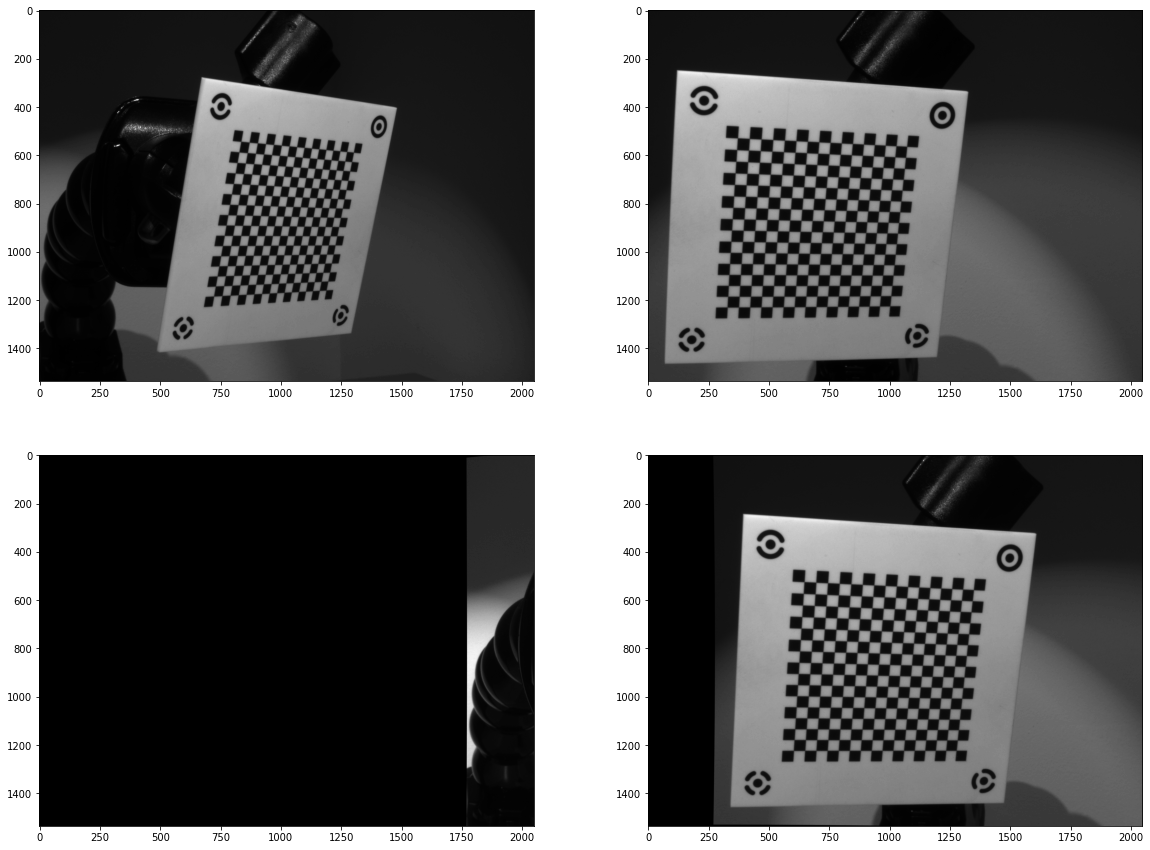

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].imshow(arr1_d, cmap='gray')
axs[0,1].imshow(arr2_d, cmap='gray')
axs[1,0].imshow(arr1_r, cmap='gray')
axs[1,1].imshow(arr2_r, cmap='gray');

First image is still out of FOV, but the second image is better aligned in Bouguet's method, which makes sense because Fusiello's method only takes the rotation of the first camera into account.

### Camera Rectification

For rectification, in terms of extrinsics, you can only rotate the cameras. This alone may cause problems if one of the cameras rotates a lot. To fix this issue, you can also modify the intrinsics (camera matrices), but they must have the following constraints:

* Focal points should be the same to ensure epipolar lines are "spaced the same"
* The y component of the principle point should be the same to ensure the lines are collinear
* The x component can be different

As long as we follow the above, the epipolar lines will be horizontal and aligned.

In [ ]:
# export
def boug_cam_rect(A1, A2, M1, M2, arr, M1_r, M2_r):
    zero = A1.new_tensor(0)
    
    (R1, _), (R1_r, _) = M2Rt(M1), M2Rt(M1_r)
    (R2, _), (R2_r, _) = M2Rt(M2), M2Rt(M2_r)
    
    # Get focal length
    alpha = stackify((A1[[0,1],[0,1]], A2[[0,1],[0,1]])).mean()
    A_alpha = stackify(((alpha, zero),
                        (zero,  alpha)))
    
    # Get new principle points such that center of image gets mapped close to rectified center
    def _get_po_pr(A, R, R_r):
        po_nr = pmm(po_p, R_r.T@R@torch.inverse(A), aug=True)
        po_pr = po_p - pmm(A_alpha, po_nr)
        return po_pr
    po_p = shape(arr)[[1,0]]/2  
    po_pr1, po_pr2 = _get_po_pr(A1, R1, R1_r), _get_po_pr(A2, R2, R2_r)
    xo_r1, xo_r2 = po_pr1[0], po_pr2[0]
    yo_r = (po_pr1[1]+po_pr2[1])/2
    
    # Create camera matrices
    def _get_A(xo_r):
        return torch.cat([torch.cat([A_alpha, stackify((((xo_r,), (yo_r,))))], dim=1), 
                          A1.new_tensor([[0, 0, 1]])])
    return _get_A(xo_r1), _get_A(xo_r2)

In [ ]:
A1_r, A2_r = boug_cam_rect(A1, A2, M1, M2, arr1_d, M1_r, M2_r)
A1_r, A2_r

(tensor([[ 3.5986e+03,  0.0000e+00, -8.7673e+02],
         [ 0.0000e+00,  3.5986e+03,  8.0350e+02],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64),
 tensor([[3.5986e+03, 0.0000e+00, 7.4263e+02],
         [0.0000e+00, 3.5986e+03, 8.0350e+02],
         [0.0000e+00, 0.0000e+00, 1.0000e+00]], dtype=torch.float64))

Rectify images

In [ ]:
H1 = rect_homography(A1, A1_r, M1, M1_r)
H2 = rect_homography(A2, A2_r, M2, M2_r)

In [ ]:
with torch.no_grad():
    arr1_r = rect_array(arr1_d, H1, cam1, distort1)
    arr2_r = rect_array(arr2_d, H2, cam2, distort2)

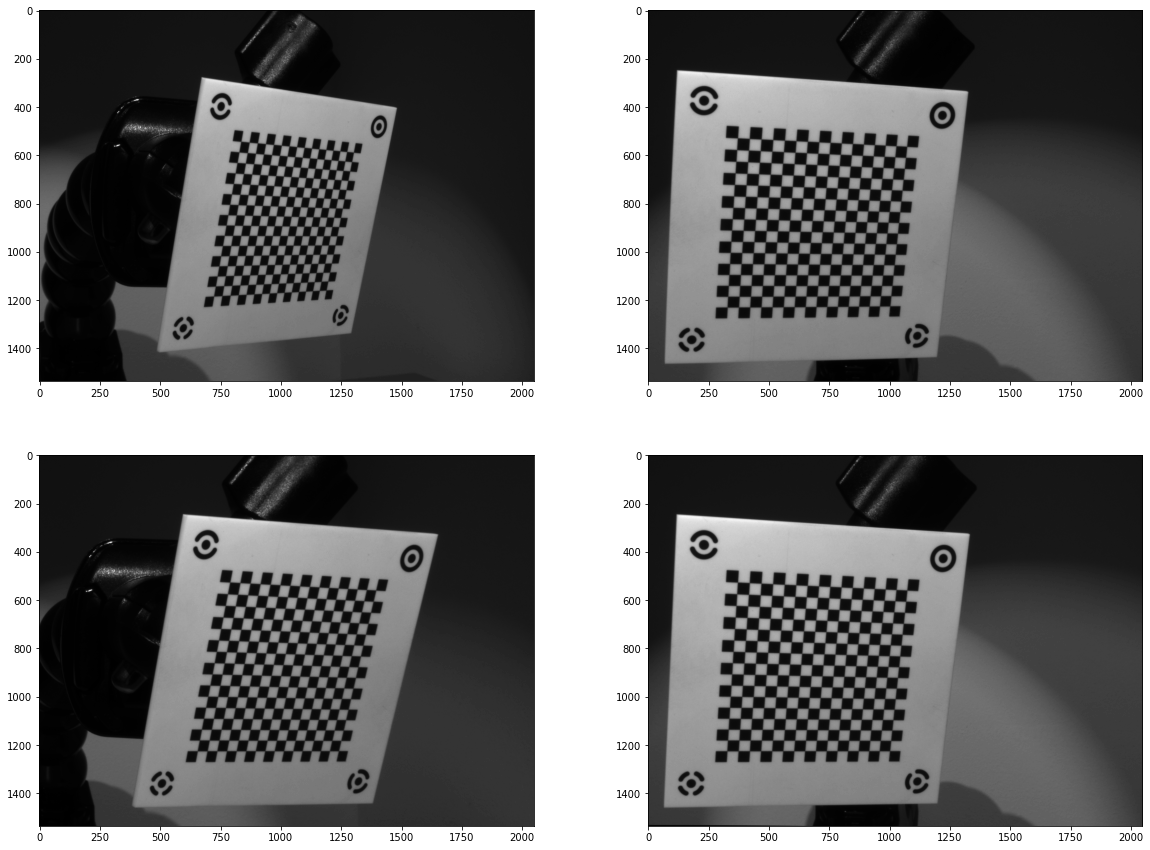

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].imshow(arr1_d, cmap='gray')
axs[0,1].imshow(arr2_d, cmap='gray')
axs[1,0].imshow(arr1_r, cmap='gray')
axs[1,1].imshow(arr2_r, cmap='gray');

Much better; plot epipolar lines to confirm they are rectified

In [ ]:
R12, t12 = M2Rt(invert_rigid(M2_r)@M1_r)

In [ ]:
F = get_fundamental(R12, t12, A1_r, A2_r)

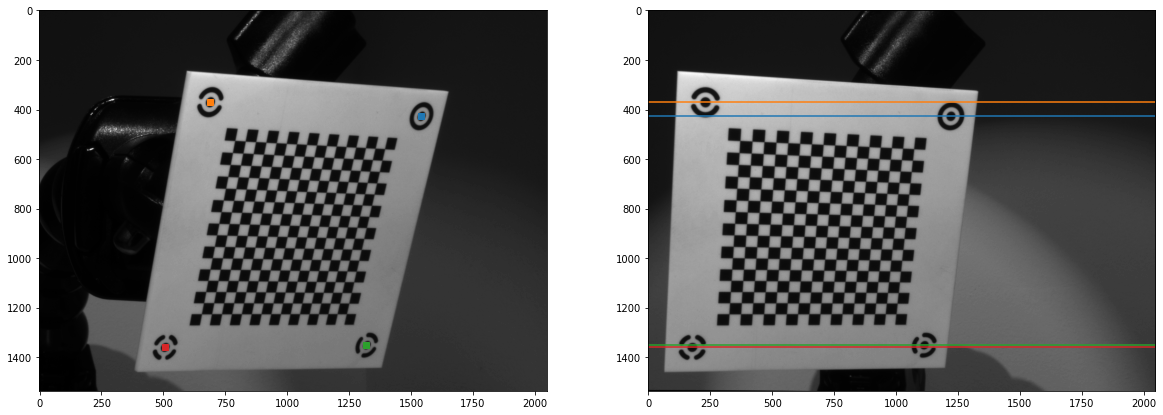

In [ ]:
plot_epi(pmm(ps1_u, torch.inverse(H1), aug=True), F, arr1_r, arr2_r)

Looks pretty good

# Build

In [ ]:
build_notebook();

<IPython.core.display.Javascript object>

Converted README.ipynb.


In [ ]:
convert_notebook()

<IPython.core.display.Javascript object>